# Large dataframe term paper (Notebook 2/2)

by Marie Orschulik (Matrikel number: 411093)

In [1]:
# Importing the pandas library, as well as standard utility modules after installing them using a virtual environment
# We need to provide the path to the mld source code

import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import sys
sys.path.append("./mld/src")
import midlevel_descriptors as mld

### Copy all wav files to one directory

In [2]:
wav_sources = 'processed/'
wav_target = 'all_wavs'

# Each file is copied into wav_target, so that all files are in the 'all_wavs' directory after this
# good to know: rglob(pattern) is also searching in the subfolders in the current working directory

for file in Path(wav_sources).rglob('*.wav'):
    if os.path.isfile(file):
        shutil.copy2(file, wav_target)

#### Fix pandas error with Q-Stimme dataframe

In [3]:
# As far as I understand it: Audio files were already a python object after the segmentation (DE: Segmentierung)
# The pickled byte stream can be used to re-create the original object hierarchy by unpickling the stream
# This process is similar to object serialization in Java or .Net

df_q = pd.read_pickle('./processed/Orschulik/Orschulik_mdf.pkl')

def re_arrange_df(df, audio_dir):
    df['segmented_file'] = df['segmented_file'].apply(lambda x: audio_dir+os.path.basename(x))
    df = df.set_index(df.segmented_file)
    df = df.drop(columns=['segmented_file', 'channel'])
    return df
df_q = re_arrange_df(df_q, 'all_wavs/')


ad ={'id':'Q-Stimme', 
     'gender': 'divers', 
     'speakertype': 'synthetic',
     'age': 35, 
     'lang':'en-GB', 
     'speechtype':'synthetic',
     'source':'https://www.genderlessvoice.com/'}
for k in ad:
    df_q[k] = ad[k]
df_q.to_pickle('Annotations/q.pkl')

df_q.head(2)

,id,gender,speakertype,age,lang,speechtype,source
segmented_file,,,,,,,
all_wavs/qstimme_Orschulik_seg_00000000.wav,Q-Stimme,divers,synthetic,35,en-GB,synthetic,https://www.genderlessvoice.com/
all_wavs/qstimme_Orschulik_seg_00000001.wav,Q-Stimme,divers,synthetic,35,en-GB,synthetic,https://www.genderlessvoice.com/


#### Fix file path with Wannenmacher dataframe

In [4]:
# Read and overwrite pickle

df_wannenmacher = pd.read_pickle('./Annotations/Apt.pkl')
df_wannenmacher.index = df_wannenmacher.index.to_series().apply(lambda x: x[3:])
df_wannenmacher.to_pickle('./Annotations/Apt.pkl')

In [5]:
df_wannenmacher.head(2)

,id,gender,speakertype,age,lang,speechtype,source
segmented_file,,,,,,,
,Daniel_Apt,male,human,28,de-DE,explanatory,YouTube
,Daniel_Apt,male,human,28,de-DE,explanatory,YouTube


### Make a dataframe with all wav files (what I will refer to as "large dataframe")

##### in 4 steps: see comments A) to D):

In [6]:
#A) Specify where your annotations are

in_directory = './Annotations/'

In [7]:
#B) Initialize your df with pandas function pd.DataFrame() and specify where your audio data is 
# use glob module to find all '*.pkl' in the audio directory and have them read into a temporary df_tmp
    
df = pd.DataFrame()
audio_directory = 'all_wavs/'
for file in glob.glob(in_directory+'*.pkl'):
    #print(file)
    df_tmp = pd.read_pickle(file)
    
#C) Unify annotations in the "try clause" and handle exceptions in the "except clause"
    try:
        df_tmp['gender'] = df_tmp.sex
        df_tmp = df_tmp.drop(columns=['sex'])
    except (KeyError, AttributeError) as e:
        pass
    
#D) Set index and append rows to get a new object: the large dataframe 'df'
    df_tmp.index = df_tmp.index.to_series().apply(lambda x: audio_directory+os.path.basename(x))
    df = df.append(df_tmp)

In [8]:
# Show all unique ids
df.id.unique()

array(['greta_thunberg', 'michelle_obama', 'alexa', 'hildegard_knef',
       'philipp.amthor', 'Daniel_Apt', 'hajo_schumacher',
       'dietmar_bartsch', 'martin_luther_king', 'Q-Stimme', 'Drosten'],
      dtype=object)

In [9]:
df.head(2)

,id,gender,speakertype,age,lang,speechtype,source
segmented_file,,,,,,,
all_wavs/Thunberg_Conle_seg_00000000.wav,greta_thunberg,female,human,17,en-EN,persuasive,https://www.youtube.com/watch?v=TMrtLsQbaok
all_wavs/Thunberg_Conle_seg_00000001.wav,greta_thunberg,female,human,17,en-EN,persuasive,https://www.youtube.com/watch?v=TMrtLsQbaok


In [10]:
# Play audio # here you hear whispering as an example (no f0 extraction in this case)
import IPython
IPython.display.Audio('all_wavs/Die-Geliebte_Haubereiser_seg_00000039.wav')

#### Extract Mid Level Descriptors (by Uwe Reichel)

In [11]:
fex_mld = mld.MLD()
mld_df = fex_mld.extract_from_index(index=df, cache_path='./test_cache3')

In [12]:
mld_df.shape

(709, 580)

In [13]:
df.shape

(794, 7)

In [14]:
794 -709
# there are 85 more segments in df than in the mld_df:

85

In [15]:
df.speakertype.unique()
# the nan (not a number) in the output below can be interpreted as value that is undefined or unrepresentable:

array(['human', 'synthetic', nan], dtype=object)

In [16]:
df.gender.unique()

array(['female', 'male', 'divers'], dtype=object)

In [17]:
df.age.unique()

array([17, 57, '30', 35, 28, 63, 49], dtype=object)

In [18]:
df.groupby(['age', 'id']).min()

gender speakertype   lang   speechtype  \
age id                                                           
17  greta_thunberg      female       human  en-EN   persuasive   
28  Daniel_Apt            male       human  de-DE  explanatory   
    philipp.amthor        male       human  de-DE       debate   
35  Q-Stimme            divers   synthetic  en-GB    synthetic   
    hildegard_knef      female       human  de-DE     personal   
    martin_luther_king    male         NaN    eng    preaching   
49  Drosten               male       human  de-DE  informative   
57  hajo_schumacher       male       human  de-DE    interview   
    michelle_obama      female       human  en-US       debate   
63  dietmar_bartsch       male       human  de-DE       debate   
30  alexa               female   synthetic     de    synthetic   

                                                                   source  
age id                                                                     
17  greta_thunberg            https://www.youtube.com/watch?v=TMrtLsQbaok  
28  Daniel_Apt                                                    YouTube  
    philipp.amthor            https://www.youtube.com/watch?v=KR1qmWyGA2Y  
35  Q-Stimme                             https://www.genderlessvoice.com/  
    hildegard_knef                       Die Geliebte Stimme, Vinyl, 1961  
    martin_luther_king  https://www.npr.org/2010/01/18/122701268/i-hav...  
49  Drosten             https://www.youtube.com/watch?v=VusAhXCQ8g4&t=...  
57  hajo_schumacher     https://www.radioeins.de/themen/kommentare_kol...  
    michelle_obama            https://www.youtube.com/watch?v=SJ45VLgbe_E  
63  dietmar_bartsch           https://www.youtube.com/watch?v=frG98KtOpiI  
30  alexa               https://play.google.com/store/apps/details?id=...

<AxesSubplot:ylabel='speechtype'>

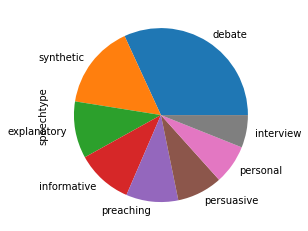

In [19]:
df.speechtype.value_counts().plot(kind='pie')

Figure 1: *The pie plot shows you the speechtype distribution. Speechtype 'debate' is the most common. Q-voice is not the only synthetic speech (I wonder about "synthetic" being a speechtype?).*

<AxesSubplot:ylabel='speakertype'>

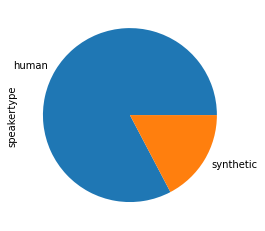

In [20]:
df.speakertype.value_counts().plot(kind='pie')

Figure 2: *Human speaker's voices vs. synthetic speaker's voices distribution.*

### Alexa vs. Q-voice and human vs. synthetic speeches

In [22]:
# Building "sub-dataframes" by extracting data from the large dataframe df, given f.e. the id of speakers:

df_alexa = df[df.id == 'alexa']
df_q = df[df.id =='Q-Stimme']

In [23]:
# Here we define a function to get mld features for speakers Alexa and Q

def get_feats(df):
    return mld_df[mld_df.index.isin(df.index)]
feats_alexa = get_feats(df_alexa)
feats_q = get_feats(df_q)

<AxesSubplot:>

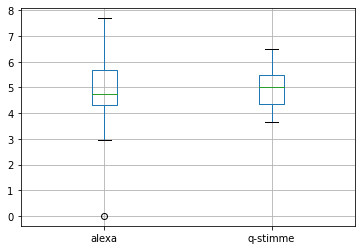

In [24]:
# The pandas function concat has the attribute rename to give a name to the according boxplots depicting speechrate

pd.concat([feats_alexa['hld_sylRate'].rename('alexa'), 
           feats_q['hld_sylRate'].rename('q-stimme')], axis=1).boxplot()

Figure 3: *Q-voice has a slightly higher speechrate than Alexa. Alexa's speechrate has a higher range of different speechrates in the according speech.*

#### Speechrates of Greta Thunderberg vs. Alexa

In [25]:
df_greta = df[df.id == 'greta_thunberg']

In [26]:
def get_feats(df):
# here we define a function to get mld features for speakers Alexa and Q
    return mld_df[mld_df.index.isin(df.index)]
feats_greta = get_feats(df_greta)

<AxesSubplot:>

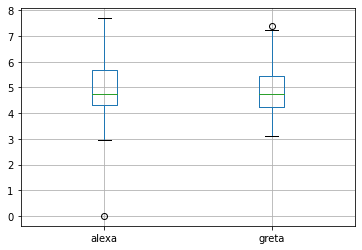

In [27]:
pd.concat([feats_alexa['hld_sylRate'].rename('alexa'), 
           feats_greta['hld_sylRate'].rename('greta')], axis=1).boxplot()

Figure 4: *Speechrates of Greta Thunderberg and Alexa look similar.*

<AxesSubplot:>

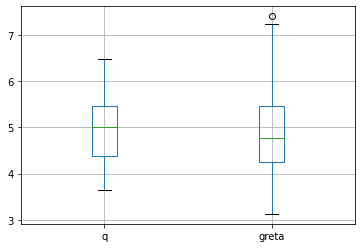

In [28]:
pd.concat([feats_q['hld_sylRate'].rename('q'), 
           feats_greta['hld_sylRate'].rename('greta')], axis=1).boxplot()

Figure 5: *Q-voice is talking more quickly and quite monotous when comparing it's speechrate with Greta's and Alexa's speechrate.*

##  Speechrate and age/ gender in the large dataframe

#### Starting with just some data exploration

In [29]:
df.columns

Index(['id', 'gender', 'speakertype', 'age', 'lang', 'speechtype', 'source'], dtype='object')

In [30]:
df.groupby(['gender'])['id'].count()

gender
divers     13
female    360
male      421
Name: id, dtype: int64

<AxesSubplot:ylabel='gender'>

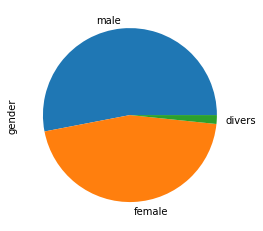

In [21]:
df.gender.value_counts().plot(kind='pie')

Figure 6: *Distribution of gender.*

In [32]:
df.age.unique()

array([17, 57, '30', 35, 28, 63, 49], dtype=object)

In [31]:
df.groupby(['id', 'age', 'gender'])['id'].count()

id                  age  gender
Daniel_Apt          28   male       84
Drosten             49   male       83
Q-Stimme            35   divers     13
alexa               30   female    111
dietmar_bartsch     63   male       80
greta_thunberg      17   female     67
hajo_schumacher     57   male       48
hildegard_knef      35   female     58
martin_luther_king  35   male       77
michelle_obama      57   female    124
philipp.amthor      28   male       49
Name: id, dtype: int64

In [33]:
df.groupby(['age', 'id']).min(1)

Empty DataFrame
Columns: []
Index: [(17, greta_thunberg), (28, Daniel_Apt), (28, philipp.amthor), (35, Q-Stimme), (35, hildegard_knef), (35, martin_luther_king), (49, Drosten), (57, hajo_schumacher), (57, michelle_obama), (63, dietmar_bartsch), (30, alexa)]

#### Let's try to get a bar plot that shows age distribution

In [34]:
s = pd.Series([17, 28, 28, 30, 35, 35, 35, 49, 57, 57, 63])
pd.to_numeric(s)

0     17
1     28
2     28
3     30
4     35
5     35
6     35
7     49
8     57
9     57
10    63
dtype: int64

In [35]:
df_tmp = s.to_frame()

In [36]:
type(0)

int

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

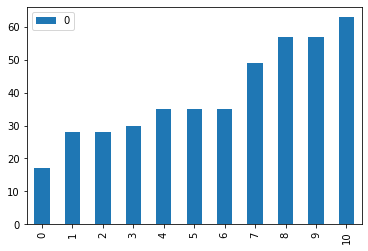

In [37]:
plt.figure()
df_tmp.plot(kind="bar")

#the barplot below serves to show the age distribuation in large_dataframe
#it is a quick but not formal (and unprofessional) graph (Figure 7)
#BUT I think it shows the age distribution better than the pie plot below it (Figure 8)

Figure 7: *Age distribution in the large dataframe shown in a bar plot.*

<AxesSubplot:ylabel='age'>

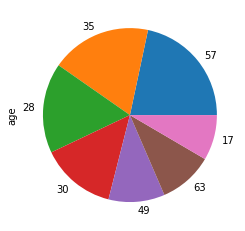

In [60]:
df.age.value_counts().plot(kind='pie')

Figure 8: *Age distribution in the large dataframe shown in a pie plot.*

In [38]:
df_female = df.groupby('gender').get_group('female')

In [39]:
df_male = df.groupby('gender').get_group('male')

In [40]:
def get_feats(df):
# here we define a function to get mld features for female vs. male speakers
    return mld_df[mld_df.index.isin(df.index)]
feats_female = get_feats(df_female)
feats_male = get_feats(df_male)

<AxesSubplot:>

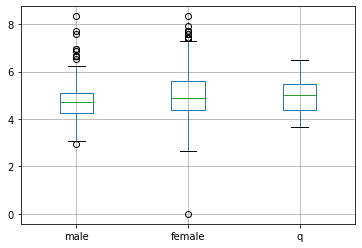

In [66]:
pd.concat([feats_male['hld_sylRate'].rename('male'), 
           feats_female['hld_sylRate'].rename('female'),
           feats_q['hld_sylRate'].rename('Q-voice')], axis=1).boxplot()

Figure 9: *Speechrate of men vs. women vs. Q-voice.*

In [67]:
df_male.columns

Index(['id', 'gender', 'speakertype', 'age', 'lang', 'speechtype', 'source'], dtype='object')

In [43]:
feats_male.columns

Index(['hld_sylRate', 'hld_gapRel', 'hld_nSyl',
       'lld_voicingFinalUnclipped_sma_diff',
       'lld_voicingFinalUnclipped_sma_end',
       'lld_voicingFinalUnclipped_sma_iqr',
       'lld_voicingFinalUnclipped_sma_median',
       'lld_voicingFinalUnclipped_sma_peak',
       'lld_voicingFinalUnclipped_sma_q_kurtosis',
       'lld_voicingFinalUnclipped_sma_q_range5',
       ...
       'rhy_f0_sm3', 'rhy_f0_sm4', 'rhy_en_mae', 'rhy_en_prop', 'rhy_en_sm1',
       'rhy_en_sm2', 'rhy_en_sm3', 'rhy_en_sm4', 'rhy_iso_pvi',
       'rhy_iso_varco'],
      dtype='object', length=580)

#### Merge dataframes: merge the feats_male/female with the df_male/female

In [44]:
df_male_merged = df_male.merge(feats_male, left_index=True, right_index=True)

In [45]:
df_male_merged.head(1)

,id,gender,speakertype,age,lang,speechtype,source,hld_sylRate,hld_gapRel,hld_nSyl,...,rhy_f0_sm3,rhy_f0_sm4,rhy_en_mae,rhy_en_prop,rhy_en_sm1,rhy_en_sm2,rhy_en_sm3,rhy_en_sm4,rhy_iso_pvi,rhy_iso_varco
all_wavs/Amthor_Nellesen_seg_00000000.wav,philipp.amthor,male,human,28,de-DE,debate,https://www.youtube.com/watch?v=KR1qmWyGA2Y,4.678363,0.017233,32,...,22.730427,108701.719195,45.153173,0.456916,4.81206,2.84244,22.730427,108701.719195,39.673828,38.230924


In [46]:
df_female_merged = df_female.merge(feats_female, left_index=True, right_index=True)

In [47]:
df_female_merged.head(1)

,id,gender,speakertype,age,lang,speechtype,source,hld_sylRate,hld_gapRel,hld_nSyl,...,rhy_f0_sm3,rhy_f0_sm4,rhy_en_mae,rhy_en_prop,rhy_en_sm1,rhy_en_sm2,rhy_en_sm3,rhy_en_sm4,rhy_iso_pvi,rhy_iso_varco
all_wavs/Thunberg_Conle_seg_00000000.wav,greta_thunberg,female,human,17,en-EN,persuasive,https://www.youtube.com/watch?v=TMrtLsQbaok,4.761905,0.243222,8,...,16.276945,23974.331766,11.661324,0.51818,4.147482,2.70571,16.276945,23974.331766,46.704387,42.257713


<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

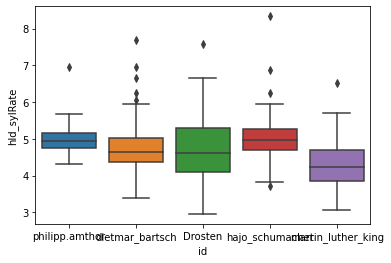

In [48]:
sns.boxplot(x='id',
            y='hld_sylRate', # Adding y here works as hue
            #hue='smoker', # You can add also another hue to have an even more granular comparison
            data = df_male_merged)

Figure 10: *Boxplots speechrate for male speakers.*

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

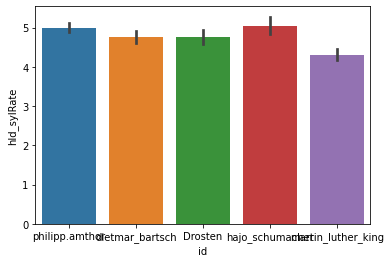

In [49]:
sns.barplot(
    x='id',
    y='hld_sylRate',
    data=df_male_merged
)

Figure 11: *Barplot speechrate per male speaker.*

*Martin Luther King talks slower than other male speakers.*

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

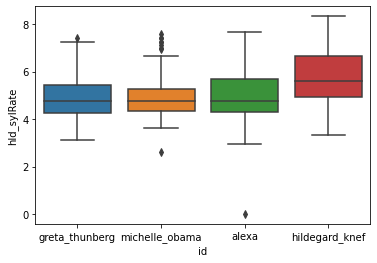

In [50]:
sns.boxplot(x='id',
            y='hld_sylRate', # Adding y here works as hue
            #hue='smoker', # You can add also another hue to have an even more granular comparison
            data = df_female_merged)

Figure 12: *Boxplots speechrate for female speakers.*

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

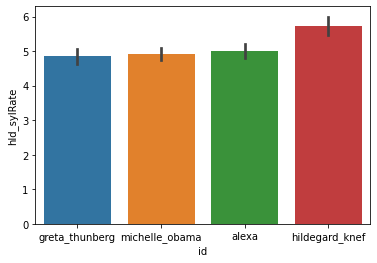

In [51]:
sns.barplot(
    x='id',
    y='hld_sylRate',
    data=df_female_merged
)

Figure 12: *Barplot speechrate per female speaker.*

*Hildegard Knef talks more quickly than other female speakers.*

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

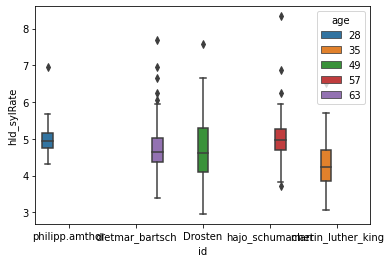

In [52]:
sns.boxplot(x='id',
            y='hld_sylRate', # Adding y here works as hue
            hue='age', # You can add also another hue to have an even more granular comparison
            data = df_male_merged)

Figure 13: *Boxplots of speechrate per male speaker showing age.*

*The 35-year-old Martin Luther King talks the slowest (lower speechrate) than the rest.*

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

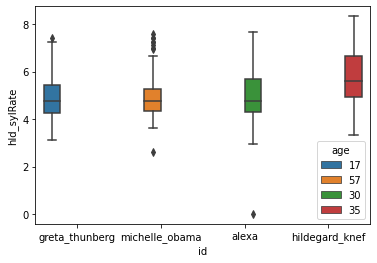

In [53]:
sns.boxplot(x='id',
            y='hld_sylRate', # Adding y here works as hue
            hue='age', # You can add also another hue to have an even more granular comparison
            data = df_female_merged)

Figure 14: *Boxplots of speechrate per female speaker showing age.*

*The 35-year-old Hildergard Knef is talking faster (higer speechrate) than the rest.*

#### Let's not forget there is a divers Q-voice

In [54]:
df_divers_merged = df_q.merge(feats_q, left_index=True, right_index=True)

<AxesSubplot:xlabel='id', ylabel='hld_sylRate'>

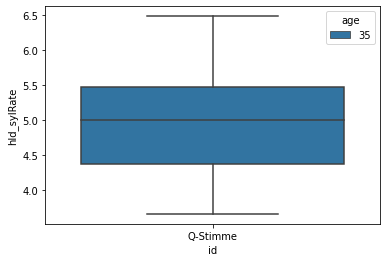

In [55]:
sns.boxplot(x='id',
            y='hld_sylRate', # Adding y here works as hue
            hue='age', # You can add also another hue to have an even more granular comparison
            data = df_divers_merged)

Figure 15: *Boxplot of speechrate Q-voice.*

*The q-stimme has a speechrate that is somewhere inbetween the speechrate of female speakers. And Q on average talks more quickly than men in the large_dataframe.*

### Short excursion: Martin Luther King and speech-/pauserate

*Martin Luther King is talking slower than other speakers and I assume he uses among others this and pauses for his his message in his speech "I have a Dream" that all men are equal, 28 August 1963 at the Lincoln Memorial in Washington D.C.*

*When I think of "I have a Dream", I think of it like of a poem with pauses inbetween the lines that are starting alike (rethorical device anaphora), f.e. also "Let freedom ring", in the following audio example:*

In [56]:
import IPython
IPython.display.Audio('all_wavs/MK_Shushana_seg_00000069.wav')

*Let's have a look how the pauserate and the speechrate correlate in the large_dataframe:*

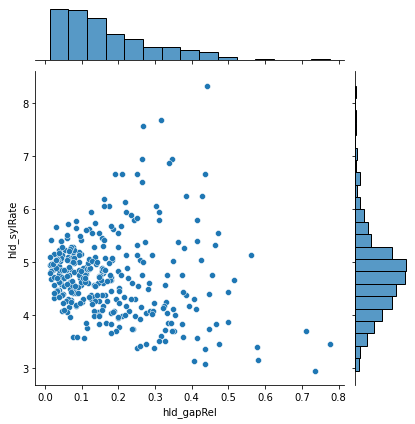

In [57]:
sns.jointplot(
    x='hld_gapRel',
    y='hld_sylRate',
    data=df_male_merged
)

Figure 16: *A so called jointplot from the seaborn library, showing speechrate (y-axis) and "pauserate" (x-axis) in scatter- and barplots.*

*Approximately, the lower the speechrate the higher the "pauserate". This is in accordance to what we see in Martin Luther King's case.* 